<a href="https://colab.research.google.com/github/Ciela-Institute/Astromatic/blob/main/Astromatic2023/p1_galaxy_morphology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of galaxy morphology

### Problem description

The formation history of galaxies is not fully understood. There are many open questions: why do some galaxies have complex spiral arm structures while others are nearly featureless ellipsoids? What dynamical processes give rise to these structures? Why do star formation rates vary so much between galaxies?

In this problem, we will be taking a large set of real SDSS observations and training a neural network to classify the galaxies by their morphology while looking for outliers.

### What is the main issue?

Catalogs of extragalactic objects are growing rapidly, and with them, the amount of data we have as astronomers to sift through. One of the most basic, and most important, analysis tools is the classification of these objects.

### What is the potential solution to this problem?

We can start by using a simple convolutional neural network to classify morphological images.

### What data will be used?

17,736 256x256 images from the [DESI Legacy Imaging Survey](https://www.legacysurvey.org/).

### Milestone estimators

- A **convolutional neural network** may be a good first step. You will need to decide on an appropriate metric to characterize its performance.
- **Pay attention to the data.** For example: how many examples are there for each morphology category? If the number differs between categories, what will you do about that? What about data augmentation or preprocessing?
- How could you detect **anomalies** in the dataset that don't fit well into any of the given categories?
- **Do you think the categories provided are a good way to classify morphology?** Can you come up with a different categorization direct from data using unsupervised learning?
- What other interesting tasks can you do with this dataset?

### Useful references:

For [Galaxy Zoo 2](https://arxiv.org/abs/1308.3496), you can consult a summary of the decision tree [here](https://data.galaxyzoo.org/gz_trees/gz_trees.html)

- [Galaxy Zoo DECaLS: Detailed Visual Morphology Measurements from Volunteers and Deep Learning for 314,000 Galaxies](https://arxiv.org/abs/2102.08414)
- [GaMPEN: A Machine Learning Framework for Estimating Bayesian Posteriors of Galaxy Morphological Parameters](https://arxiv.org/abs/2207.05107)
- [Machine and Deep Learning Applied to Galaxy Morphology -- A Comparative Study](https://arxiv.org/abs/1901.07047)
- [Galaxy morphological classification in deep-wide surveys via unsupervised machine learning](https://arxiv.org/abs/1909.10537)
- [Galaxy morphology classification using automated machine learning](https://www.sciencedirect.com/science/article/abs/pii/S2213133721000469)
- [Machine Learning for Galaxy Morphology Classification](https://ui.adsabs.harvard.edu/abs/2010arXiv1005.0390G/abstract)
- [Machine learning technique for morphological classification of galaxies from the SDSS](https://www.aanda.org/articles/aa/full_html/2021/04/aa38981-20/aa38981-20.html)

## Setup

Creates a PyTorch dataset class to wrap the DECALs dataset. We use the version preprocessed by [astroNN](https://astronn.readthedocs.io/en/latest/index.html). The plot shows an example from the dataset. Note the colors are not the true observed colors -- the telescope uses the [g, r and z bands](https://en.wikipedia.org/wiki/Photometric_system).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import h5py
import numpy as np
import os, glob
from torch.nn import functional as F
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
import torch
from astropy.visualization import make_lupton_rgb

decals_path = "drive/MyDrive/Astromatic2023/Data/DECaLS_dr10.h5"
galaxyzoo_path = "drive/MyDrive/Astromatic2023/Data/GalaxyZoo/"

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


# Unzip Galaxy Zoo 2 images locally

Note that you could also download the images either from the [Kaggle challenge](https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data) or the [official data release ](https://data.galaxyzoo.org/). We are providing to you the Kaggle dataset.

In [ ]:
!unzip -qqn drive/MyDrive/Astromatic2023/Data/GalaxyZoo/images_training_rev1.zip

# Datasets

In [ ]:
decals_classes = {
    0: "Disturbed Galaxy",
    1: "Merging Galaxy",
    2: "Round Smooth Galaxy",
    3: "In-between Round Smooth Galaxy",
    4: "Cigar Shaped Smooth Galaxy",
    5: "Barred Spiral Galaxy",
    6: "Unbarred Tight Spiral Galaxy",
    7: "Unbarred Loose Spiral Galaxy",
    8: "Edge-on Galaxy without Bulge",
    9: "Edge-on Galaxy with Bulge"
}

galaxyzoo_classes = {
    0: 'Smooth galaxy',
    1: 'Features or disk',
    2: 'Star or artifact',

    # For features or disk galaxies:
    3: 'Edge-on',
    4: 'Not edge-on',

    # For edge-on galaxies:
    5: 'Has a boxy bulge',
    6: 'Has no bulge',
    7: 'Has a round bulge',

    # For not edge-on galaxies:
    8: 'Spiral arms',
    9: 'No spiral arms',

    # Spiral arm properties:
    10: 'Tight spiral',
    11: 'Medium spiral',
    12: 'Loose spiral',

    # For not edge-on with no spiral arms:
    13: 'Bulge dominance - No bulge',
    14: 'Bulge dominance - Just noticeable',
    15: 'Bulge dominance - Obvious',
    16: 'Bulge dominance - Dominant',

    17: 'Rounded central bulge',
    18: 'Boxy central bulge',
    19: 'No central bulge',

    # For anything else (not just spirals):
    20: 'Ring',
    21: 'Lens or arc',
    22: 'Disturbed',
    23: 'Irregular',
    24: 'Other',
    25: 'Merging',
    26: 'Tidal debris',
    27: 'Rounded',
    28: 'Odd',

    29: 'Dust lane',
    30: 'No dust lane',
    31: "Can't tell",
    32: 'Tight arm winding',
    33: 'Medium arm winding',
    34: 'Loose arm winding',
    35: 'One arm',
    36: 'Two arms',
    37: 'Three arms'
}
# For the GalaxyZoo classifier, it can be easier to only try to predict a subset of the classes

In [ ]:
# This dataset should not be shuffle (much slower to load data when shuffled)
class DECaLSDataset(torch.utils.data.Dataset):
    def __init__(self, path: str = decals_path, downsample:int=0, device=DEVICE):
        self.file = h5py.File(path, mode="r")
        self.images = self.file["images"]
        self.classes = self.file["ans"]
        self.redshifts = self.file["redshift"]
        self._len = len(self.images)
        self.k = downsample
        self.device = device

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        img = torch.tensor(self.images[index]).float().to(self.device)
        img = torch.permute(img, (2, 0, 1)) # move channels first
        morphology = torch.tensor(self.classes[index]).int().to(self.device)
        redshift = torch.tensor(self.redshifts[index]).float().to(self.device)

        # A good trick to simplify the problem is to downsample the image by some factor of 2
        img = F.avg_pool2d(img, 2**self.k)

        return img, morphology, redshift

# GalaxyZoo is much faster than DECaLS (thus will be easier to use, and can be shuffled)
class GalaxyZooDataset(torch.utils.data.Dataset):
    def __init__(self, shape, path: str = galaxyzoo_path, downsample:int=0):
        self.votes = pd.read_csv(os.path.join(galaxyzoo_path, "training_solutions_rev1.csv"), index_col=0)
        self.img_files = glob.glob("images_training_rev1/*.jpg")
        self._len = len(self.img_files)
        self.shape = shape
        self.galaxy_ids = np.array([int(os.path.split(f)[-1][:-4]) for f in self.img_files])
        self.k = downsample

    def index_to_galaxyid(self, index):
        # remove .jpg from file name and return it as an integer
        return self.galaxy_ids[index]

    def galaxyid_to_index(self, galaxy_indices:list):
        return [np.argwhere(self.galaxy_ids == i)[0][0] for i in galaxy_indices]

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        img = np.array(Image.open(self.img_files[index]))
        # Center crop the image to wanted shape
        img = img / 255 # convert pixel values to the range [0, 1]
        img = torch.tensor(img).float().to(DEVICE)
        img = torch.permute(img, [2, 0, 1]) # move channel first
        img = T.CenterCrop(self.shape)(img) # crop to a standard shape

        # A good trick to simplify the problem is to downsample the image by some factor of 2
        img = F.avg_pool2d(img, 2**self.k)

        # Load the class associated with our img
        img_id = self.index_to_galaxyid(index)
        class_votes = self.votes.loc[img_id]
        class_votes = torch.tensor(class_votes.to_numpy()).float()
        class_prob = class_votes / class_votes.sum() # turn class votes into probabilities
        return img, class_prob

# DECaLS Family Portrait

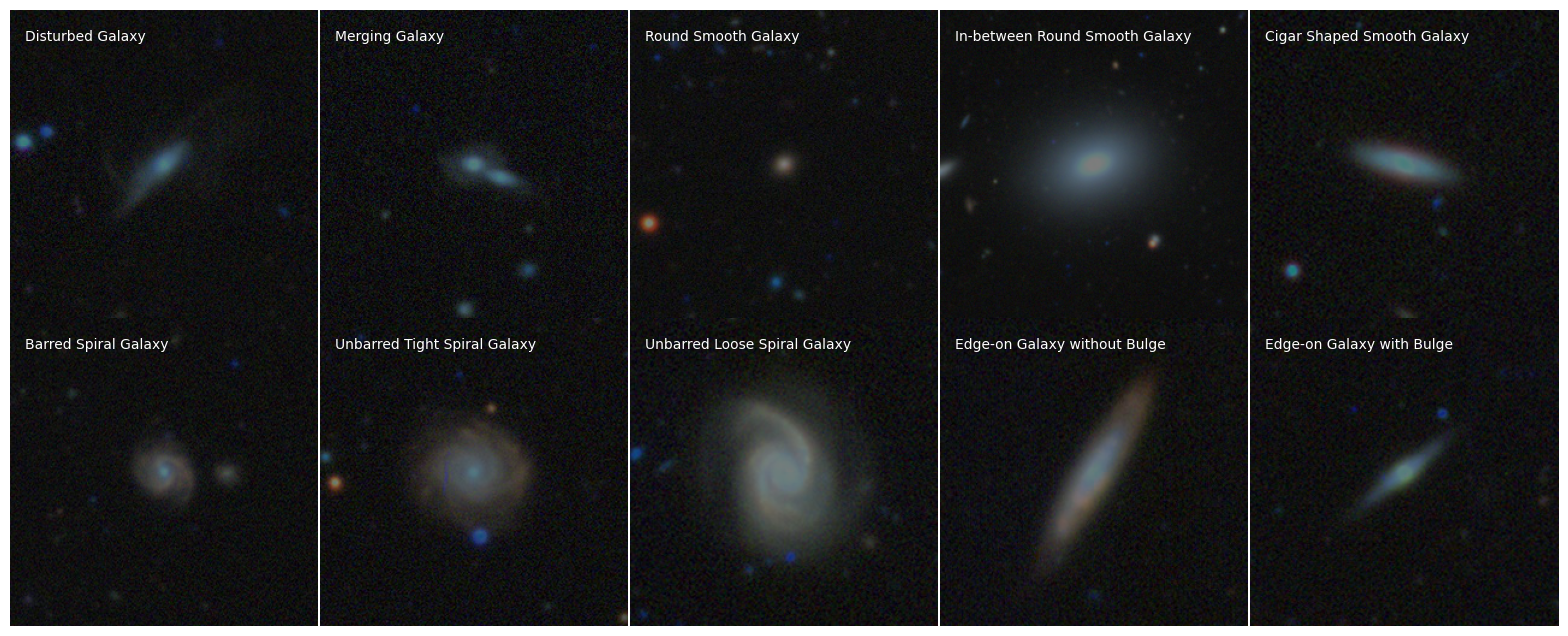

In [ ]:
dataset = DECaLSDataset()
# Load the classes
classes = dataset.classes[:]
# For each class, pick an index (randomly) and plot it
fig, axs = plt.subplots(2, 5, figsize=(5*4, 2*4))
for i in range(len(decals_classes)):
    ax = axs[i//5, i%5]
    class_indices = np.argwhere(classes == i).flatten()
    k = np.random.choice(class_indices, size=1)[0]
    img, morphology, _ = dataset[k] # load the image from the dataset
    # Make sure tensor are on cpu for plotting
    img = img.cpu()
    morphology = morphology.cpu()
    # Make an RGB image (RGB = zrg)
    rgb_img = make_lupton_rgb(img[2], img[1], img[0], stretch=5e2, Q=1)
    ax.imshow(rgb_img)
    ax.annotate(decals_classes[morphology.item()], xy=(0.05, 0.9), xycoords="axes fraction", color="w", fontsize=10)
    ax.axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

# Galaxy Zoo Family Portrait

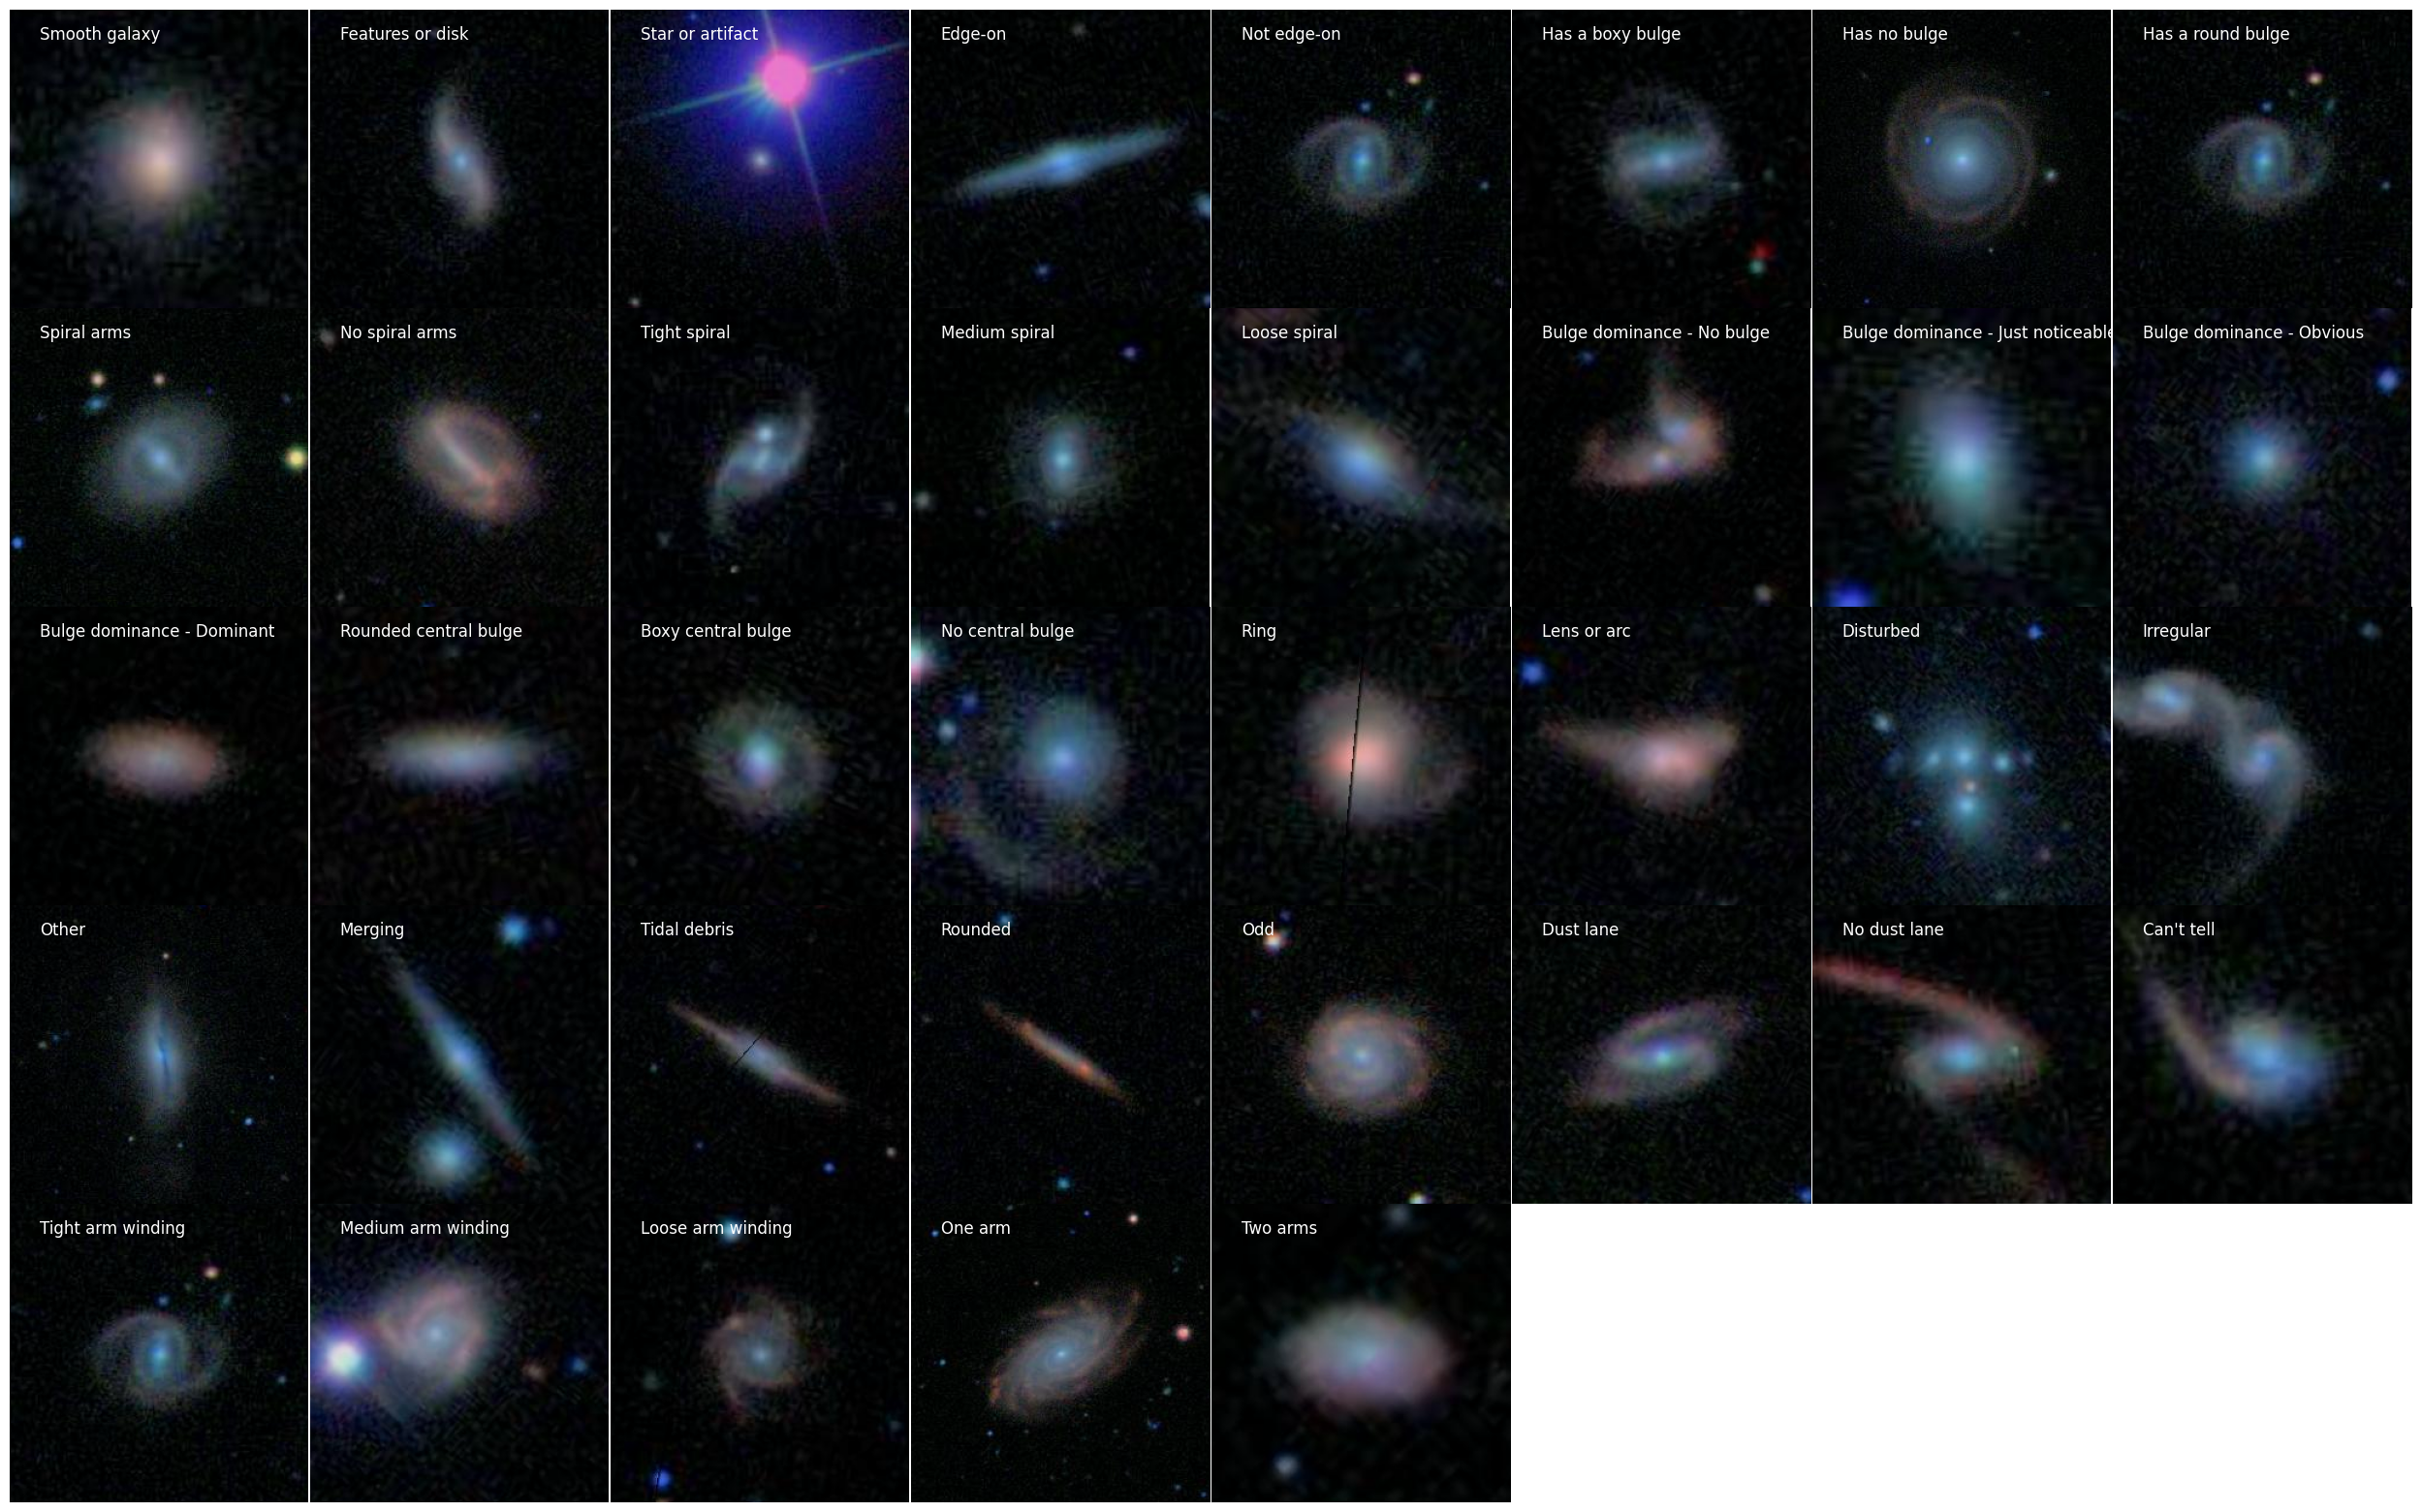

In [ ]:
# Galaxy Zoo 2 Family Portrait
dataset = GalaxyZooDataset(shape=[256, 256])

# For each class, plot the most representative image for each class
representative_gids = dataset.votes.idxmax().tolist()
representative_idx = dataset.galaxyid_to_index(representative_gids)

fig, axs = plt.subplots(5, 8, figsize=(32, 20))
for i in range(5):
    for j in range(8):
        k = i * 8 + j
        if k < 37:
            ind = representative_idx[k]
            img, _= dataset[ind]
            img = img.cpu()
            # Make an RGB image (RGB = zrg)
            rgb_img = make_lupton_rgb(img[2], img[1], img[0], stretch=1, Q=1)
            axs[i, j].imshow(rgb_img)
            axs[i, j].annotate(galaxyzoo_classes[k], xy=(0.1, 0.9), xycoords="axes fraction", fontsize=12, color="w")
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)


# Your solution

In [ ]:
dataset = ...
B = ...
dataloader = DataLoader(dataset, batch_size=B, shuffle=True) # Don't shuffle DECaLS